# Atelier 2 : Classification - Machine Learning

Université Abdelmalek Essaâdi · FST Tanger · Département GI

Cycle Ingénieur LSI – 2023/2024 · Encadrant : Pr. EL AACHAK LOTFI

Notebook inspiré du canevas de l'Atelier 1 (régression) : même structure dossiers (`dataset/`, `figures/`, `models/`, `notebooks/`).


In [2]:
import os
import pathlib
import warnings
from typing import Dict, List

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    AdaBoostClassifier,
    BaggingClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    StackingClassifier,
)
from sklearn.feature_selection import RFE, SelectKBest, mutual_info_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    log_loss,
    roc_auc_score,
)
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

plt.style.use("seaborn-v0_8")
warnings.filterwarnings("ignore")
RANDOM_STATE = 42
PROJECT_ROOT = pathlib.Path("..").resolve()
DATA_PATH = PROJECT_ROOT / "dataset" / "diabetes.csv"
FIG_PATH = PROJECT_ROOT / "figures"
MODEL_PATH = PROJECT_ROOT / "models"
FIG_PATH.mkdir(parents=True, exist_ok=True)
MODEL_PATH.mkdir(parents=True, exist_ok=True)

In [3]:
def fetch_diabetes_dataset(path: pathlib.Path) -> pd.DataFrame:
    """Charge le jeu de données local ou télécharge une version publique fallback.

    - Préférence : fichier Kaggle placé dans `dataset/diabetes.csv`.
    - Fallback : dataset public GitHub (mêmes colonnes) si le fichier n'existe pas.
    """

    if path.exists():
        df = pd.read_csv(path)
        return df

    fallback_url = "https://raw.githubusercontent.com/plotly/datasets/master/diabetes.csv"
    print(f"[info] Fichier absent. Téléchargement de secours depuis {fallback_url}")
    df = pd.read_csv(fallback_url)
    path.parent.mkdir(parents=True, exist_ok=True)
    df.to_csv(path, index=False)
    return df


df = fetch_diabetes_dataset(DATA_PATH)
df.head()


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
# Vue d'ensemble
print(df.shape)
print("\nTypes:\n", df.dtypes)
print("\nValeurs manquantes:\n", df.isnull().sum())

# Colonnes où la valeur 0 est physiologiquement improbable -> on imputera plus tard
zero_as_missing = [
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
]

# Comptage des zéros
(df[zero_as_missing] == 0).sum()



(768, 9)

Types:
 Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

Valeurs manquantes:
 Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


Glucose            5
BloodPressure     35
SkinThickness    227
Insulin          374
BMI               11
dtype: int64

In [5]:
# Remplacement des 0 aberrants par NaN puis imputation médiane
clean_df = df.copy()
clean_df[zero_as_missing] = clean_df[zero_as_missing].replace(0, np.nan)

median_values = clean_df.median(numeric_only=True)
clean_df = clean_df.fillna(median_values)

print("Valeurs manquantes après imputation:")
print(clean_df.isnull().sum())

# Renommer la cible pour cohérence (Outcome -> target)
clean_df = clean_df.rename(columns={"Outcome": "target"})

clean_df.describe(include="all")



Valeurs manquantes après imputation:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,target
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.656250,72.386719,29.108073,140.671875,32.455208,0.471876,33.240885,0.348958
std,3.369578,30.438286,12.096642,8.791221,86.383060,6.875177,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,25.000000,121.500000,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,29.000000,125.000000,32.300000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


target
0    0.651042
1    0.348958
Name: ratio, dtype: float64


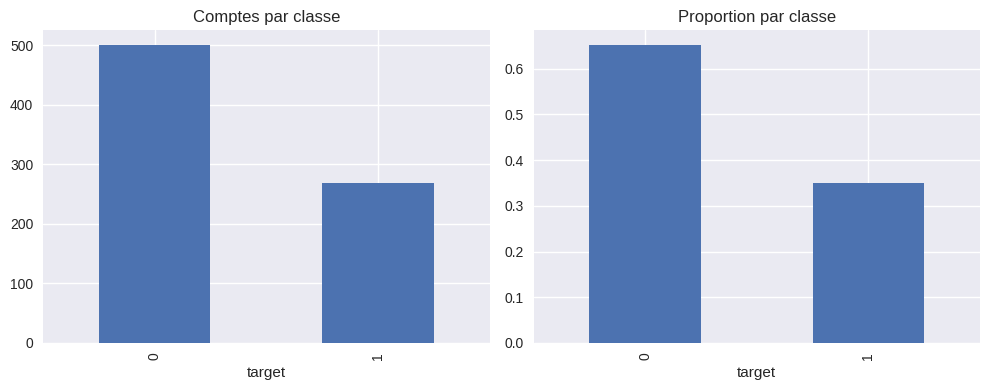

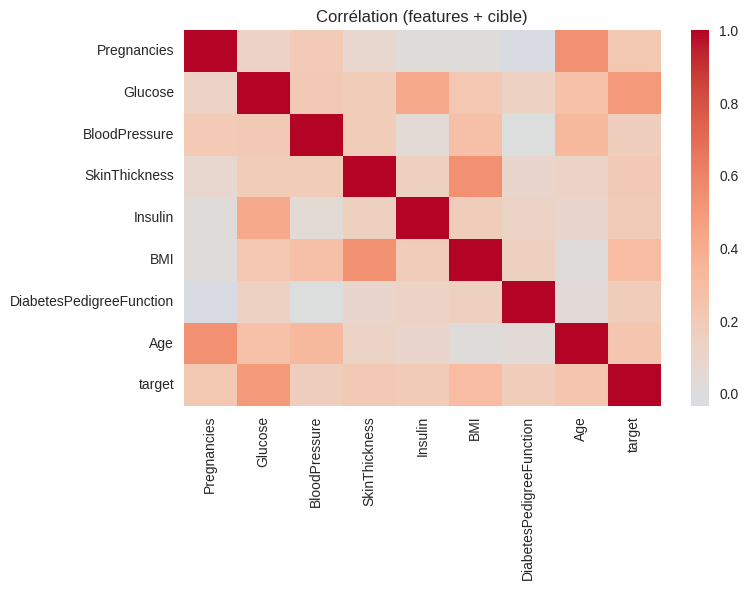

In [6]:
# Distribution de la cible
class_counts = clean_df["target"].value_counts(normalize=True).rename("ratio")
print(class_counts)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
clean_df["target"].value_counts().plot(kind="bar", ax=ax[0], title="Comptes par classe")
class_counts.plot(kind="bar", ax=ax[1], title="Proportion par classe")
plt.tight_layout()
plt.show()

# Matrice de corrélation
plt.figure(figsize=(8, 6))
sns.heatmap(clean_df.corr(), annot=False, cmap="coolwarm", center=0)
plt.title("Corrélation (features + cible)")
plt.tight_layout()
plt.savefig(FIG_PATH / "correlation_heatmap_diabetes.png", dpi=120)
plt.show()



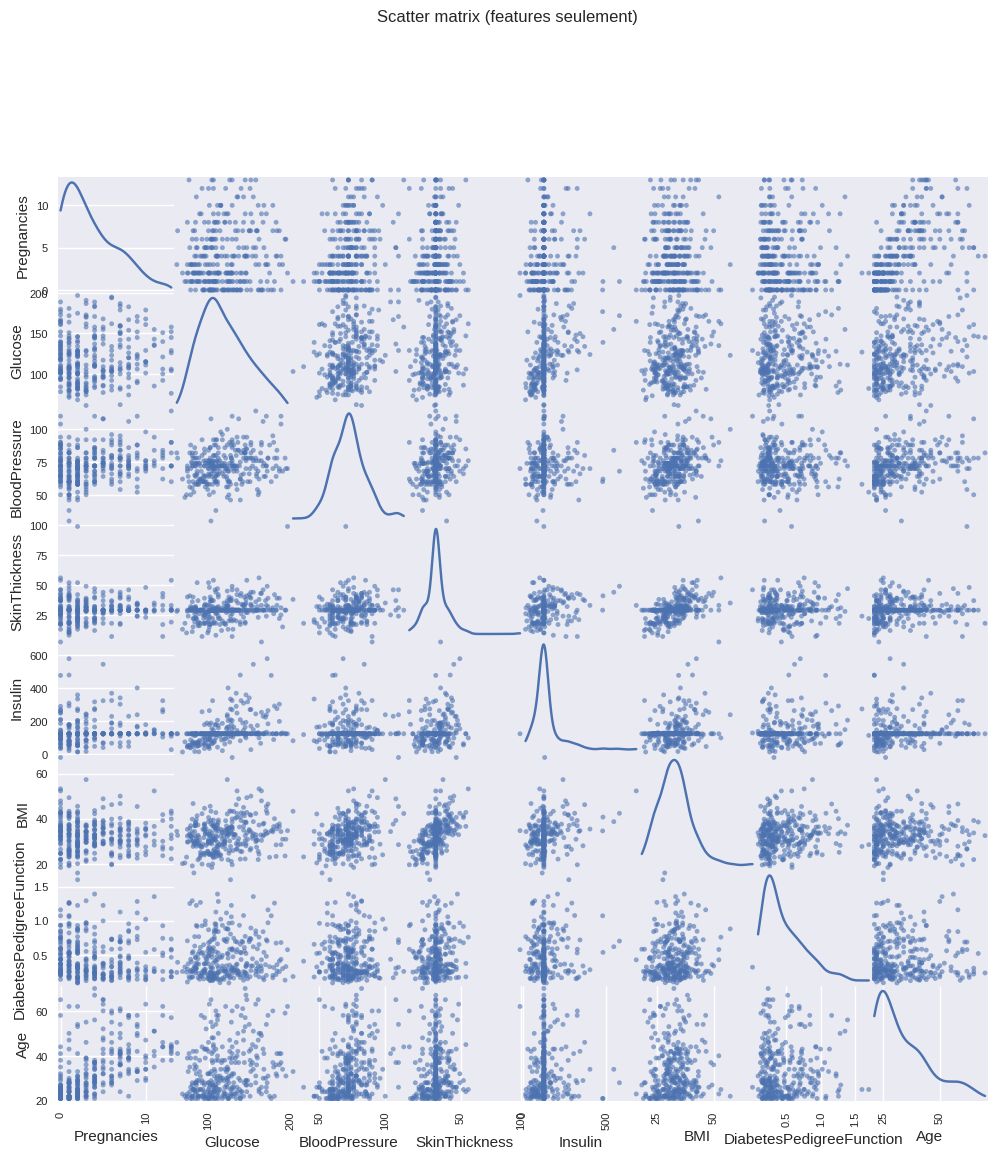

In [7]:
# Nuage de points (échantillon pour lisibilité)
sample_df = clean_df.sample(n=min(300, len(clean_df)), random_state=RANDOM_STATE)
pd.plotting.scatter_matrix(sample_df.drop(columns=["target"]), figsize=(12, 12), diagonal="kde", alpha=0.6)
plt.suptitle("Scatter matrix (features seulement)", y=1.02)
plt.savefig(FIG_PATH / "scatter_matrix_diabetes.png", dpi=120, bbox_inches="tight")
plt.show()

Glucose                     0.129283
BMI                         0.089056
Age                         0.082227
Pregnancies                 0.049581
Insulin                     0.035240
SkinThickness               0.033204
BloodPressure               0.020642
DiabetesPedigreeFunction    0.008780
dtype: float64


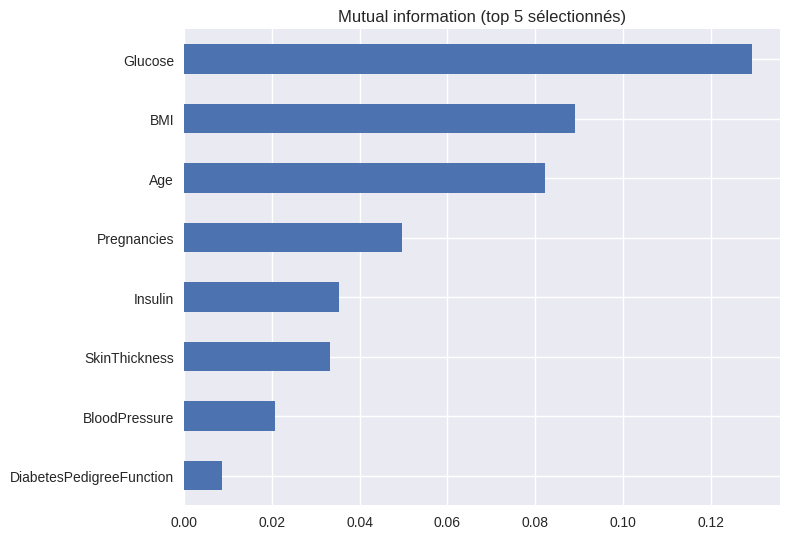

Features retenues : ['Pregnancies', 'Glucose', 'Insulin', 'BMI', 'Age']


In [7]:
# Feature Selection : Univariate (mutual information)
X = clean_df.drop(columns=["target"])
y = clean_df["target"]

selector = SelectKBest(score_func=mutual_info_classif, k=5)
selector.fit(X, y)

uni_scores = pd.Series(selector.scores_, index=X.columns).sort_values(ascending=False)
print(uni_scores)

uni_scores.plot(kind="barh", title="Mutual information (top 5 sélectionnés)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

selected_features = list(X.columns[selector.get_support()])
print("Features retenues :", selected_features)



PC1    0.285373
PC2    0.472320
PC3    0.615008
PC4    0.729574
PC5    0.825682
PC6    0.893592
PC7    0.952148
PC8    1.000000
dtype: float64


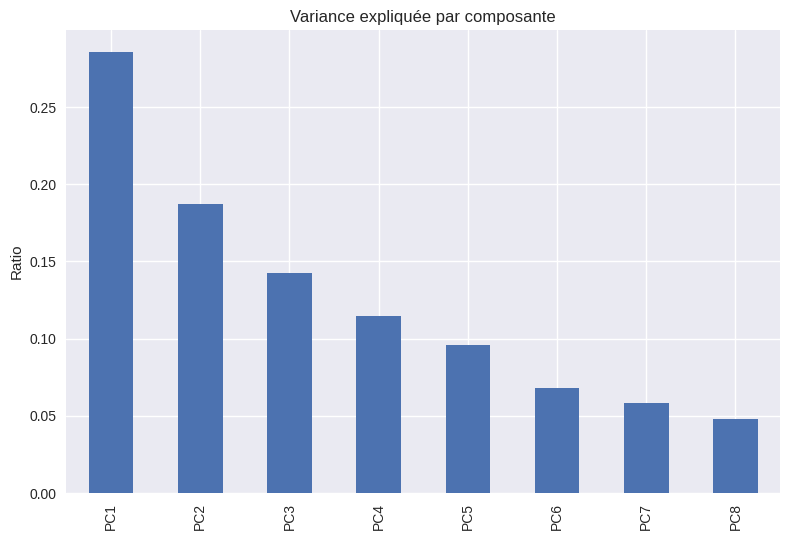

In [8]:
# PCA (StandardScaler + PCA)
scaler = StandardScaler()
pca = PCA(n_components=8, random_state=RANDOM_STATE)

X_scaled = scaler.fit_transform(X)
pca.fit(X_scaled)

exp_var = pd.Series(pca.explained_variance_ratio_, index=[f"PC{i+1}" for i in range(pca.n_components_)])
print(exp_var.cumsum())

exp_var.plot(kind="bar", title="Variance expliquée par composante")
plt.ylabel("Ratio")
plt.tight_layout()
plt.show()



In [9]:
# Recursive Feature Elimination (Logistic Regression L2)
log_reg = LogisticRegression(max_iter=1000, solver="lbfgs")
rfe = RFE(log_reg, n_features_to_select=5)
rfe.fit(X_scaled, y)

rfe_support = pd.Series(rfe.support_, index=X.columns)
print("Features retenues (RFE):", list(rfe_support[rfe_support].index))



Features retenues (RFE): ['Pregnancies', 'Glucose', 'BMI', 'DiabetesPedigreeFunction', 'Age']


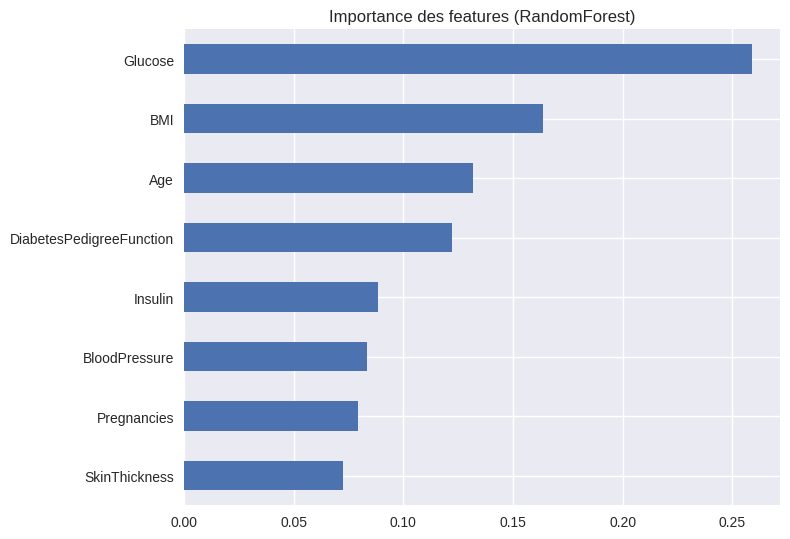

In [10]:
# Feature importance (RandomForest)
rf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
rf.fit(X, y)
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values()

importances.plot(kind="barh", title="Importance des features (RandomForest)")
plt.tight_layout()
plt.show()



In [8]:
# Jeu d'entraînement / test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)
print(f"Train: {X_train.shape}, Test: {X_test.shape}")



Train: (614, 8), Test: (154, 8)


In [9]:
def build_models() -> Dict[str, Pipeline]:
    scaler = StandardScaler()
    models = {
        "knn": Pipeline([
            ("scaler", scaler),
            ("model", KNeighborsClassifier(n_neighbors=7)),
        ]),
        "decision_tree": DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
        "mlp": Pipeline([
            ("scaler", scaler),
            (
                "model",
                MLPClassifier(hidden_layer_sizes=(32, 16), max_iter=500, random_state=RANDOM_STATE),
            ),
        ]),
        "naive_bayes": GaussianNB(),
        "svm_linear": Pipeline([
            ("scaler", scaler),
            ("model", SVC(kernel="linear", probability=True, random_state=RANDOM_STATE)),
        ]),
        "svm_poly": Pipeline([
            ("scaler", scaler),
            ("model", SVC(kernel="poly", degree=3, probability=True, random_state=RANDOM_STATE)),
        ]),
        "svm_rbf": Pipeline([
            ("scaler", scaler),
            ("model", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
        ]),
    }
    return models


models = build_models()
list(models.keys())


['knn',
 'decision_tree',
 'mlp',
 'naive_bayes',
 'svm_linear',
 'svm_poly',
 'svm_rbf']

In [10]:
def evaluate_model(name: str, model, X_train, y_train, X_test, y_test) -> Dict[str, float]:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    else:
        # fallback pour modèles sans proba (non utilisé ici car tous proposent proba)
        y_scores = model.decision_function(X_test)
        # Min-max scaling sur scores
        y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min() + 1e-8)

    metrics = {
        "model": name,
        "accuracy": accuracy_score(y_test, y_pred),
        "log_loss": log_loss(y_test, y_proba, labels=[0, 1]),
        "roc_auc": roc_auc_score(y_test, y_proba),
    }
    print(f"\n=== {name} ===")
    print("Accuracy:", metrics["accuracy"])
    print("Log loss:", metrics["log_loss"])
    print("ROC AUC:", metrics["roc_auc"])
    print("Confusion matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification report:\n", classification_report(y_test, y_pred))
    return metrics



In [17]:
# Spot-checking (validation croisée accuracy)
spot_results = []
for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=5, scoring="accuracy")
    spot_results.append({
        "model": name,
        "cv_mean": scores.mean(),
        "cv_std": scores.std(),
    })
    print(f"{name}: {scores.mean():.3f} (+/- {scores.std():.3f})")

spot_df = pd.DataFrame(spot_results).sort_values(by="cv_mean", ascending=False)
spot_df



knn: 0.742 (+/- 0.019)
decision_tree: 0.751 (+/- 0.036)
mlp: 0.751 (+/- 0.033)
naive_bayes: 0.750 (+/- 0.024)
mlp: 0.751 (+/- 0.033)
naive_bayes: 0.750 (+/- 0.024)
svm_linear: 0.766 (+/- 0.014)
svm_linear: 0.766 (+/- 0.014)
svm_poly: 0.733 (+/- 0.014)
svm_poly: 0.733 (+/- 0.014)
svm_rbf: 0.753 (+/- 0.024)
svm_rbf: 0.753 (+/- 0.024)


,model,cv_mean,cv_std
4,svm_linear,0.765648,0.014452
6,svm_rbf,0.752670,0.024425
2,mlp,0.751388,0.033211
1,decision_tree,0.751345,0.035647
3,naive_bayes,0.750047,0.023789
0,knn,0.742221,0.019103
5,svm_poly,0.733113,0.014097


In [11]:
metrics_list = []
for name, model in models.items():
    metrics = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    metrics_list.append(metrics)
    joblib.dump(model, MODEL_PATH / f"{name}.joblib")

metrics_df = pd.DataFrame(metrics_list).sort_values(by="roc_auc", ascending=False)
metrics_df




=== knn ===
Accuracy: 0.7272727272727273
Log loss: 1.1553951524363084
ROC AUC: 0.7900000000000001
Confusion matrix:
 [[82 18]
 [24 30]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80       100
           1       0.62      0.56      0.59        54

    accuracy                           0.73       154
   macro avg       0.70      0.69      0.69       154
weighted avg       0.72      0.73      0.72       154


=== decision_tree ===
Accuracy: 0.7597402597402597
Log loss: 1.2415362515015032
ROC AUC: 0.7622222222222222
Confusion matrix:
 [[78 22]
 [15 39]]
Classification report:
               precision    recall  f1-score   support

           0       0.84      0.78      0.81       100
           1       0.64      0.72      0.68        54

    accuracy                           0.76       154
   macro avg       0.74      0.75      0.74       154
weighted avg       0.77      0.76      0.76       154


=== mlp ===
A

,model,accuracy,log_loss,roc_auc
4,svm_linear,0.701299,0.509743,0.813148
2,mlp,0.727273,0.606719,0.805000
5,svm_poly,0.714286,0.568154,0.802407
6,svm_rbf,0.740260,0.528238,0.796389
0,knn,0.727273,1.155395,0.790000
3,naive_bayes,0.701299,0.944044,0.764630
1,decision_tree,0.759740,1.241536,0.762222


In [19]:
# Rechargement des modèles sauvegardés et prédiction de contrôle
loaded_preds = {}
for name in models.keys():
    loaded_model = joblib.load(MODEL_PATH / f"{name}.joblib")
    loaded_preds[name] = loaded_model.predict(X_test[:5])

loaded_preds



{'knn': array([1, 0, 0, 0, 0]),
 'decision_tree': array([1, 0, 0, 1, 0]),
 'mlp': array([1, 0, 0, 0, 0]),
 'naive_bayes': array([1, 0, 0, 0, 0]),
 'svm_linear': array([1, 0, 0, 0, 0]),
 'svm_poly': array([0, 0, 0, 0, 0]),
 'svm_rbf': array([1, 0, 0, 0, 0])}

In [12]:
# Ensemble learning
bagging = BaggingClassifier(
    estimator=DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE),
    n_estimators=50,
    random_state=RANDOM_STATE,
)

stacking = StackingClassifier(
    estimators=[
        (
            "knn",
            Pipeline([
                ("scaler", StandardScaler()),
                ("model", KNeighborsClassifier(n_neighbors=7)),
            ]),
        ),
        ("tree", DecisionTreeClassifier(max_depth=5, random_state=RANDOM_STATE)),
        (
            "svm_rbf",
            Pipeline([
                ("scaler", StandardScaler()),
                ("model", SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)),
            ]),
        ),
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    passthrough=True,
    stack_method="predict_proba",
)

boosting = GradientBoostingClassifier(random_state=RANDOM_STATE)
ada = AdaBoostClassifier(random_state=RANDOM_STATE)

ensemble_models = {
    "bagging_tree": bagging,
    "stacking": stacking,
    "grad_boost": boosting,
    "adaboost": ada,
}

ensemble_metrics = []
for name, model in ensemble_models.items():
    m = evaluate_model(name, model, X_train, y_train, X_test, y_test)
    ensemble_metrics.append(m)
    joblib.dump(model, MODEL_PATH / f"{name}.joblib")

ensemble_df = pd.DataFrame(ensemble_metrics).sort_values(by="roc_auc", ascending=False)
ensemble_df




=== bagging_tree ===
Accuracy: 0.7337662337662337
Log loss: 0.5044840295430231
ROC AUC: 0.814074074074074
Confusion matrix:
 [[84 16]
 [25 29]]
Classification report:
               precision    recall  f1-score   support

           0       0.77      0.84      0.80       100
           1       0.64      0.54      0.59        54

    accuracy                           0.73       154
   macro avg       0.71      0.69      0.69       154
weighted avg       0.73      0.73      0.73       154


=== stacking ===
Accuracy: 0.7012987012987013
Log loss: 0.513922003850692
ROC AUC: 0.8112962962962963
Confusion matrix:
 [[81 19]
 [27 27]]
Classification report:
               precision    recall  f1-score   support

           0       0.75      0.81      0.78       100
           1       0.59      0.50      0.54        54

    accuracy                           0.70       154
   macro avg       0.67      0.66      0.66       154
weighted avg       0.69      0.70      0.70       154


=== stackin

,model,accuracy,log_loss,roc_auc
2,grad_boost,0.759740,0.495675,0.831481
3,adaboost,0.746753,0.566713,0.817963
0,bagging_tree,0.733766,0.504484,0.814074
1,stacking,0.701299,0.513922,0.811296


In [13]:
# Comparaison finale (modèles individuels + ensembles)
combined_df = pd.concat([
    metrics_df.assign(kind="base"),
    ensemble_df.assign(kind="ensemble"),
]).sort_values(by="roc_auc", ascending=False)
combined_df.reset_index(drop=True)

,model,accuracy,log_loss,roc_auc,kind
0,grad_boost,0.759740,0.495675,0.831481,ensemble
1,adaboost,0.746753,0.566713,0.817963,ensemble
2,bagging_tree,0.733766,0.504484,0.814074,ensemble
3,svm_linear,0.701299,0.509743,0.813148,base
4,stacking,0.701299,0.513922,0.811296,ensemble
5,mlp,0.727273,0.606719,0.805000,base
6,svm_poly,0.714286,0.568154,0.802407,base
7,svm_rbf,0.740260,0.528238,0.796389,base
8,knn,0.727273,1.155395,0.790000,base
9,naive_bayes,0.701299,0.944044,0.764630,base


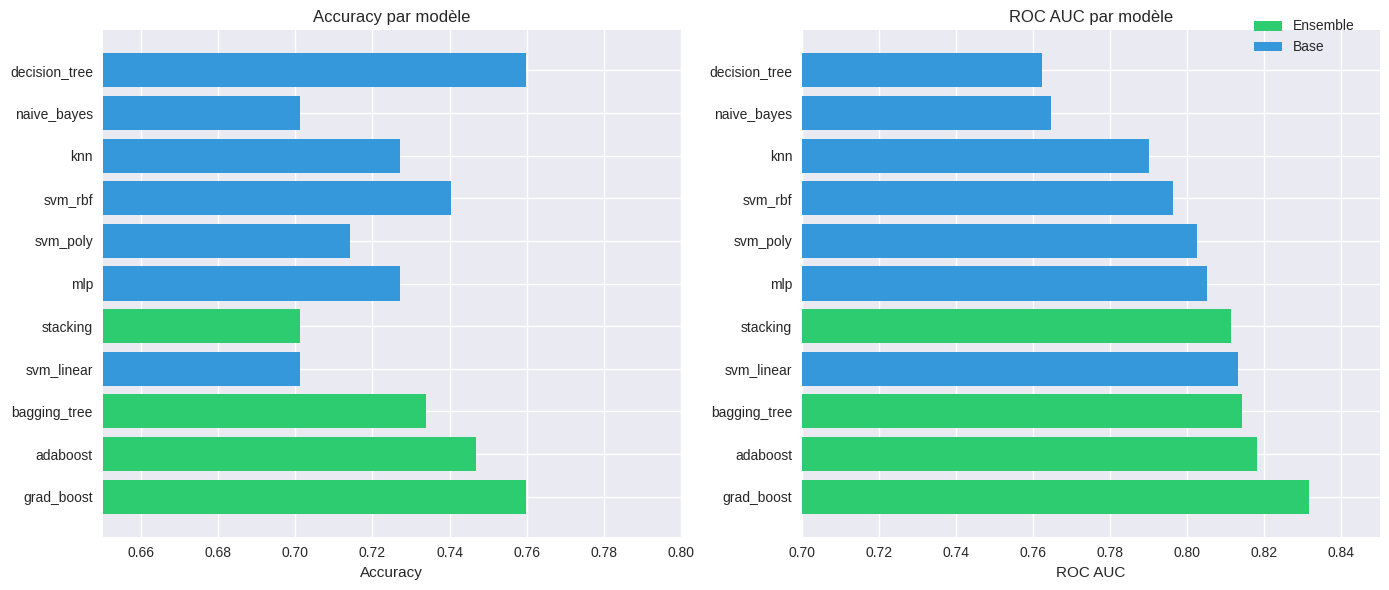

Figure sauvegardée dans : /home/medgm/ML/Atelier2_Classification/figures/model_comparison.png


In [14]:
# Visualisation comparative des modèles
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Graphique 1 : Accuracy par modèle
colors = ['#2ecc71' if k == 'ensemble' else '#3498db' for k in combined_df['kind']]
axes[0].barh(combined_df['model'], combined_df['accuracy'], color=colors)
axes[0].set_xlabel('Accuracy')
axes[0].set_title('Accuracy par modèle')
axes[0].set_xlim(0.65, 0.80)

# Graphique 2 : ROC AUC par modèle
axes[1].barh(combined_df['model'], combined_df['roc_auc'], color=colors)
axes[1].set_xlabel('ROC AUC')
axes[1].set_title('ROC AUC par modèle')
axes[1].set_xlim(0.70, 0.85)

# Légende
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor='#2ecc71', label='Ensemble'),
                   Patch(facecolor='#3498db', label='Base')]
fig.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(0.98, 0.98))

plt.tight_layout()
plt.savefig(FIG_PATH / "model_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

print(f"Figure sauvegardée dans : {FIG_PATH / 'model_comparison.png'}")